In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymatreader import read_mat
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from scipy.signal import hilbert, windows
import scipy.ndimage

## Human Arm data 불러오기

In [2]:
arm_img_mat = read_mat('data/arm/arm_Img.mat')
arm_img = np.array(arm_img_mat['img'])
print(arm_img[0])
print(arm_img.shape)

[[ 42358.8874826   45071.20090156  45533.28649614 ...  44456.76361542
   46223.91503657  44939.74564974]
 [ 66465.57812635  67006.96938247  67652.82845831 ...  67188.61032576
   67325.24979063  65683.34550986]
 [ 40623.07227203  42594.80923225  43216.95892558 ...  42173.63235641
   42638.15708899  42717.42193251]
 ...
 [156757.25946281 157206.57895115 158659.59657634 ... 157826.33870975
  157859.36992466 157088.08386599]
 [141828.80796267 141394.42066352 142544.61334902 ... 142093.7345832
  141769.13913881 141429.64969441]
 [159030.17999558 160409.82051017 161454.41278721 ... 160232.47155969
  160869.99743406 158210.23045318]]
(374, 128, 10)


## Arm 결과 이미지부터 확인하기

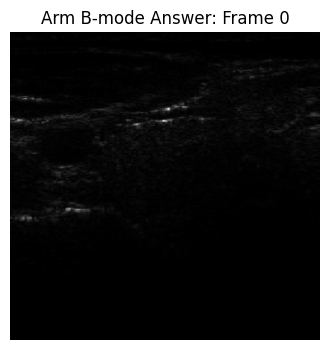

In [3]:
arm_img0 = arm_img[:, :, 0]
plt.figure(figsize=(4, 4))
plt.imshow(arm_img0, cmap='gray', aspect='auto', origin='upper')
plt.title('Arm B-mode Answer: Frame 0')
plt.axis('off')
plt.show()

In [4]:
arm_rdata_mat = read_mat('data/arm/arm_rfdata.mat')
arm_rdata = np.array(arm_rdata_mat['rfdata'])
print(arm_rdata[0])
print(arm_rdata.shape)

[[-43 -39 -41 ... -41 -41 -39]
 [-53 -51 -52 ... -52 -55 -53]
 [-44 -47 -45 ... -44 -44 -44]
 ...
 [-45 -47 -46 ... -47 -47 -47]
 [  1  -1   0 ...   0   0  -1]
 [-35 -32 -37 ... -33 -36 -30]]
(2176, 128, 100)


## Arm의 Raw Data Processing

In [ ]:
# m으로 통일 시키기 speed of sound가 m/s이므로 
trans_element = 128

#DAS 목표
col_pixels = 128
row_pixels = 2000 # >1600 pixels, 40mm/2000 = 0.02mm
col_spacing = (3.84/col_pixels) * 0.01
row_spacing = (4.0/row_pixels) * 0.01

In [6]:
delay = np.zeros((row_pixels, col_pixels, trans_element), dtype=np.float32)
x_e = (np.arange(trans_element)-(trans_element-1)/2)*col_spacing
x_p = (np.arange(col_pixels)-(col_pixels-1)/2)*col_spacing
z_p = np.arange(row_pixels) * row_spacing

Xe = x_e.reshape(1, 1, trans_element)   # (1,1,128)
Xp = x_p.reshape(1, col_pixels, 1)   # (1,128,1)
Zp = z_p.reshape(row_pixels, 1, 1)   # (2000,1,1)
distances = np.sqrt((Xp - Xe)**2 + Zp**2)

In [7]:
distances

array([[[0.00000000e+00, 3.00000000e-04, 6.00000000e-04, ...,
         3.75000000e-02, 3.78000000e-02, 3.81000000e-02],
        [3.00000000e-04, 0.00000000e+00, 3.00000000e-04, ...,
         3.72000000e-02, 3.75000000e-02, 3.78000000e-02],
        [6.00000000e-04, 3.00000000e-04, 0.00000000e+00, ...,
         3.69000000e-02, 3.72000000e-02, 3.75000000e-02],
        ...,
        [3.75000000e-02, 3.72000000e-02, 3.69000000e-02, ...,
         0.00000000e+00, 3.00000000e-04, 6.00000000e-04],
        [3.78000000e-02, 3.75000000e-02, 3.72000000e-02, ...,
         3.00000000e-04, 0.00000000e+00, 3.00000000e-04],
        [3.81000000e-02, 3.78000000e-02, 3.75000000e-02, ...,
         6.00000000e-04, 3.00000000e-04, 0.00000000e+00]],

       [[2.00000000e-05, 3.00665928e-04, 6.00333241e-04, ...,
         3.75000053e-02, 3.78000053e-02, 3.81000052e-02],
        [3.00665928e-04, 2.00000000e-05, 3.00665928e-04, ...,
         3.72000054e-02, 3.75000053e-02, 3.78000053e-02],
        [6.00333241e-04, 

In [8]:
c = 1540 
center_freq = 7.6e6
samples_per_wave = 4.1
fs = center_freq * samples_per_wave

delay_rx = (distances / c) * fs

total_path = Zp + distances  
delay_tx_rx = (total_path / c) * fs

In [ ]:
n_samples, n_elements, n_frames = arm_rdata.shape

beamformed2 = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)

sample_idx = np.arange(n_samples)  

theta = np.deg2rad(30)
max_lateral = z_p / np.cos(theta/2)
mask = distances <= max_lateral[:,None,None]

w = windows.hann(n_elements, sym=False)  # (128,)

for f in range(n_frames):
    for e in range(n_elements):
        sig = arm_rdata[:, e, f] 
        ds = delay_tx_rx[:, :, e]
        interp_func = interp1d(sample_idx, sig,kind='linear',bounds_error=False,fill_value=0.0)
        delayed = interp_func(ds) 
        delayed[~mask[:,:,e]] = 0
        beamformed2[:,:,f] += delayed * w[e]

In [15]:
beamformed2

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.19204107e-02, -3.07158660e-02, -3.13181393e-02, ...,
         -3.13181393e-02, -3.31249535e-02, -3.19204107e-02],
        [-1.05936013e-01, -1.13158926e-01, -1.08343653e-01, ...,
         -1.05936013e-01, -1.05936013e-01, -1.05936013e-01],
        ...,
        [-2.43528530e-01, -2.54352003e-01, -2.48940274e-01, ...,
         -2.54352003e-01, -2.54352003e-01, -2.54352003e-01],
        [ 2.40763673e-03, -2.40763673e-03,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -2.40763673e-03],
        [-2.10795160e-02, -1.92727000e-02, -2.22840607e-02, ...,
         -1.98749732e-02, -2.16817874e-02, -1.80681571e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.92175648e-02, -5.99628165e-02, -6.10525385e-02, ...,
         -6.10525385e-02, -6.04221076e

## Arm Envelope

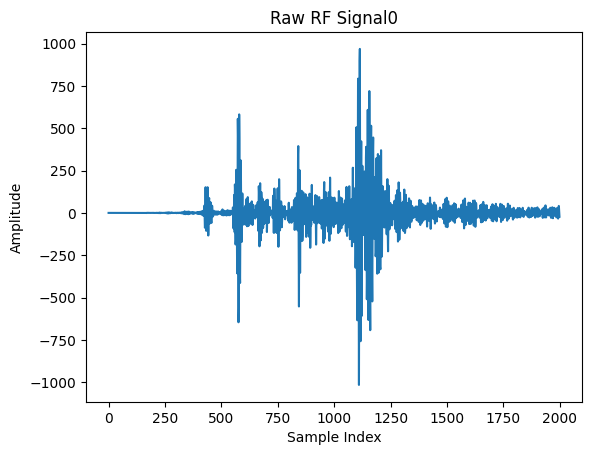

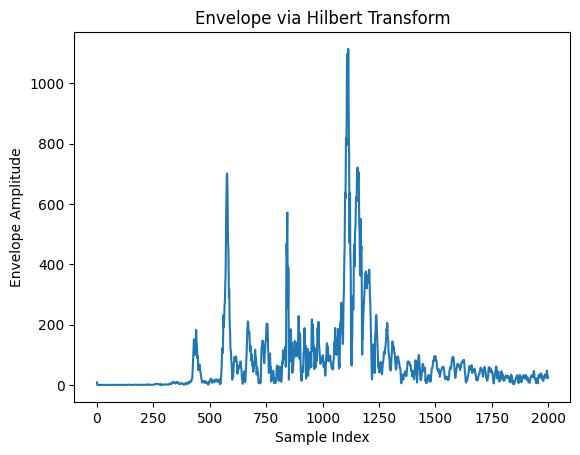

In [16]:
sig_02 = beamformed2[:, 0, 0]
analytic_sig_02 = hilbert(sig_02, axis = 0)
envelope_02 = np.abs(analytic_sig_02)

plt.figure()
plt.plot(sig_02)
plt.title('Raw RF Signal0')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
plt.plot(envelope_02)
plt.title('Envelope via Hilbert Transform')
plt.xlabel('Sample Index')
plt.ylabel('Envelope Amplitude')
plt.show()

In [17]:
envelope2 = np.abs(hilbert(beamformed2, axis=0))

## Arm Log Compression & Scan Conversion

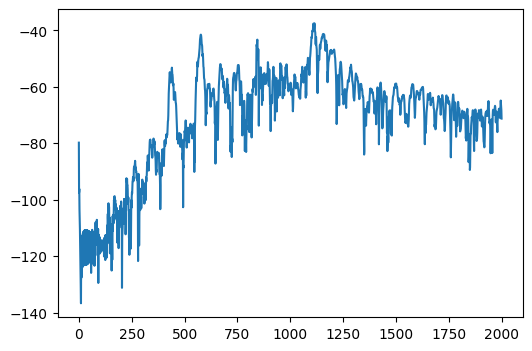

In [18]:
env0 = envelope2[:, :, 0]
env_db = 20*np.log10(env0/np.max(env0)+1e-12)

plt.figure(figsize=(6, 4))
plt.plot(env_db[:,0])
plt.show()

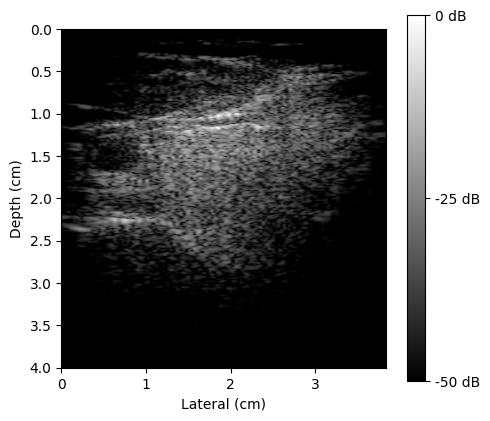

In [ ]:
env_db_clipped = np.clip(env_db, -50, 0)
bmode_400 = scipy.ndimage.zoom(env_db_clipped,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_400, cmap='gray',vmin=-50, vmax=0, origin='upper',extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

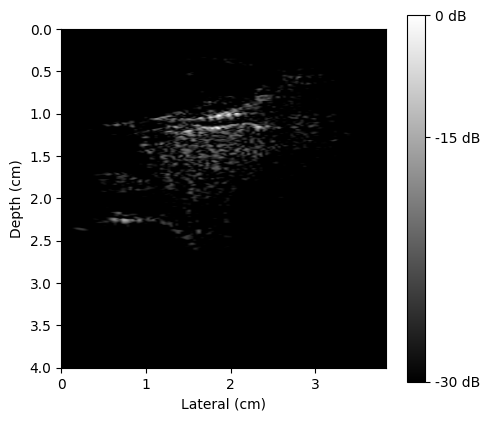

In [ ]:
env_db_clipped25 = np.clip(env_db, -30, 0)
bmode25 = scipy.ndimage.zoom(env_db_clipped25,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode25, cmap='gray',vmin=-30, vmax=0, origin='upper',extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-30, -10, 0])
cbar.set_ticklabels(['-30 dB','-15 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

# CF

In [22]:
arm_rdata

array([[[ -43,  -39,  -41, ...,  -41,  -41,  -39],
        [ -53,  -51,  -52, ...,  -52,  -55,  -53],
        [ -44,  -47,  -45, ...,  -44,  -44,  -44],
        ...,
        [ -45,  -47,  -46, ...,  -47,  -47,  -47],
        [   1,   -1,    0, ...,    0,    0,   -1],
        [ -35,  -32,  -37, ...,  -33,  -36,  -30]],

       [[ -73,  -71,  -68, ...,  -76,  -72,  -73],
        [-109, -111, -113, ..., -113, -111, -109],
        [ -80,  -85,  -82, ...,  -82,  -81,  -82],
        ...,
        [ -83,  -80,  -82, ...,  -86,  -83,  -85],
        [ -54,  -51,  -53, ...,  -53,  -54,  -57],
        [ -52,  -55,  -53, ...,  -55,  -50,  -53]],

       [[ -11,  -13,  -11, ...,  -13,  -12,  -15],
        [  -8,  -10,   -8, ...,  -10,   -4,   -6],
        [  -3,    2,   -2, ...,   -2,   -2,   -4],
        ...,
        [   4,    7,    9, ...,    7,    9,    8],
        [ -55,  -52,  -52, ...,  -51,  -54,  -52],
        [  -9,  -13,   -8, ...,  -11,   -8,  -15]],

       ...,

       [[  -3,    6,    

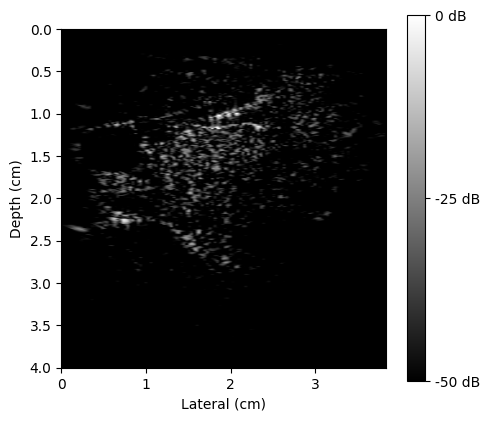

In [9]:
n_samples, n_elements, n_frames = arm_rdata.shape
beamformed_cf = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)
sample_idx = np.arange(n_samples)
theta = np.deg2rad(30)
max_lateral = z_p / np.cos(theta/2)
mask = distances <= max_lateral[:, None, None]
w = windows.hann(n_elements, sym=False)

for f in range(n_frames):
    signals = np.zeros((row_pixels, col_pixels, n_elements), dtype=np.float32)
    
    for e in range(n_elements):
        sig = arm_rdata[:, e, f] 
        ds = delay_tx_rx[:, :, e]
        interp_fn = interp1d(sample_idx, sig, kind='linear', bounds_error=False, fill_value=0.0)
        delayed = interp_fn(ds) 
        delayed[~mask[:, :, e]] = 0 
        signals[:, :, e] = delayed * w[e]
    
    sum_sig   = np.sum(signals, axis=2) 
    abs_sum2  = np.abs(sum_sig)**2 

    sum_sq    = np.sum(np.abs(signals)**2, axis=2) 

    L = 0
    M = signals.shape[2]
    cf = abs_sum2 / (M * sum_sq + 1e-12)   
    norm = 1.0 / (M -L + 1)   
    y_sum = sum_sig * norm 
    beamformed_cf[:,:,f] = y_sum * cf
    beamformed_cf[:, :, f] = sum_sig * cf
    
envelope_cf = np.abs(hilbert(beamformed_cf, axis=0))
env0cf = envelope_cf[:, :, 0]
env_dbcf = 20*np.log10(env0cf/np.max(env0cf)+1e-12)

env_cli_cf = np.clip(env_dbcf, -50, 0)
bmode_cf = scipy.ndimage.zoom(env_cli_cf,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_cf, cmap='gray',vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

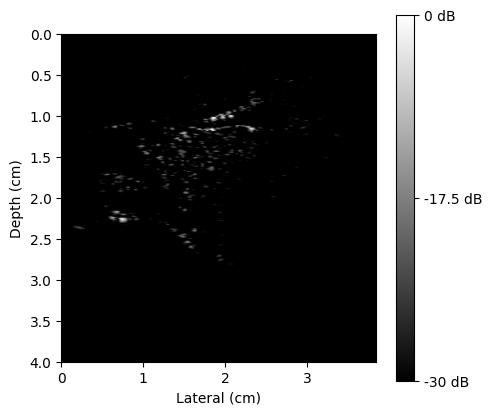

In [13]:
env_cli_cf = np.clip(env_dbcf, -35, 0)
bmode_cf = scipy.ndimage.zoom(env_cli_cf,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_cf, cmap='gray',vmin=-35, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-35, -17.5, 0])
cbar.set_ticklabels(['-30 dB','-17.5 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()